# Using a Multiple Layer Network


We will illustrate how to use a Multiple Layer Network in TensorFlow

### Low Birthrate data:
```
#Columns    Variable                                      Abbreviation
#---------------------------------------------------------------------
# Low Birth Weight (0 = Birth Weight >= 2500g,            LOW
#                          1 = Birth Weight < 2500g)
# Age of the Mother in Years                              AGE
# Weight in Pounds at the Last Menstrual Period           LWT
# Race (1 = White, 2 = Black, 3 = Other)                  RACE
# Smoking Status During Pregnancy (1 = Yes, 0 = No)       SMOKE
# History of Premature Labor (0 = None  1 = One, etc.)    PTL
# History of Hypertension (1 = Yes, 0 = No)               HT
# Presence of Uterine Irritability (1 = Yes, 0 = No)      UI
# Birth Weight in Grams                                   BWT
#---------------------------------------------------------------------
```
The multiple neural network layer we will create will be composed of three fully connected hidden layers, with node sizes 50, 25, and 5

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import os
import os.path
import random
import numpy as np
import random
import requests
from tensorflow.python.framework import ops

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Obtain the data

In [2]:
# name of data file
birth_weight_file = 'birth_weight.csv'

# download data and create data file if file does not exist in current directory
if not os.path.exists(birth_weight_file):
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, "w") as f:
        writer = csv.writer(f)
        writer.writerows([birth_header])
        writer.writerows(birth_data)
        f.close()

# read birth weight data into memory
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append(row)

birth_data = [[float(x) for x in row] for row in birth_data]


# Extract y-target (birth weight)
y_vals = np.array([x[8] for x in birth_data])

# Filter for features of interest
cols_of_interest = ['AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HT', 'UI']
x_vals = np.array([[x[ix] for ix, feature in enumerate(birth_header) if feature in cols_of_interest] for x in birth_data])

## Train model

In [3]:
# reset the graph for new run
ops.reset_default_graph()

# Create graph session 
sess = tf.Session()

# set batch size for training
batch_size = 100

# make results reproducible
seed = 3
np.random.seed(seed)
tf.set_random_seed(seed)

# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]


# Normalize by column (min-max norm to be between 0 and 1)
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)
    
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))


# Define Variable Functions (weights and bias)
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return(weight)
    

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return(bias)
    
    
# Create Placeholders
x_data = tf.placeholder(shape=[None, 7], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)


# Create a fully connected layer:
def fully_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return(tf.nn.relu(layer))


#--------Create the first layer (50 hidden nodes)--------
weight_1 = init_weight(shape=[7, 25], st_dev=10.0)
bias_1 = init_bias(shape=[25], st_dev=10.0)
layer_1 = fully_connected(x_data, weight_1, bias_1)

#--------Create second layer (25 hidden nodes)--------
weight_2 = init_weight(shape=[25, 10], st_dev=10.0)
bias_2 = init_bias(shape=[10], st_dev=10.0)
layer_2 = fully_connected(layer_1, weight_2, bias_2)


#--------Create third layer (5 hidden nodes)--------
weight_3 = init_weight(shape=[10, 3], st_dev=10.0)
bias_3 = init_bias(shape=[3], st_dev=10.0)
layer_3 = fully_connected(layer_2, weight_3, bias_3)


#--------Create output layer (1 output value)--------
weight_4 = init_weight(shape=[3, 1], st_dev=10.0)
bias_4 = init_bias(shape=[1], st_dev=10.0)
final_output = fully_connected(layer_3, weight_4, bias_4)

# Declare loss function (L1)
loss = tf.reduce_mean(tf.abs(y_target - final_output))

# Declare optimizer
my_opt = tf.train.AdamOptimizer(0.05)
train_step = my_opt.minimize(loss)

# Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
test_loss = []
for i in range(200):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    test_temp_loss = sess.run(loss, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_loss.append(test_temp_loss)
    if (i+1) % 25 == 0:
        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_loss))

Generation: 25. Loss = 5622.842
Generation: 50. Loss = 2633.468
Generation: 75. Loss = 2492.912
Generation: 100. Loss = 2275.6975
Generation: 125. Loss = 2089.1477
Generation: 150. Loss = 2178.2178
Generation: 175. Loss = 2027.2738
Generation: 200. Loss = 2271.147


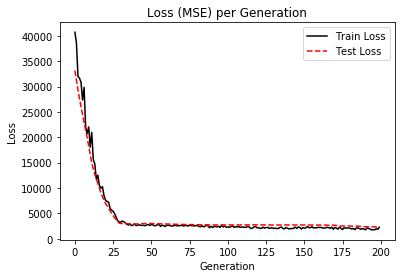

In [4]:
%matplotlib inline
# Plot loss (MSE) over time
plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.legend(loc='upper right')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [ ]:
tested; Gopal